<a href="https://colab.research.google.com/github/Sambhav300899/Neural-Style-Transfer-TF/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the repository for style and content image samples

In [2]:
!git clone https://github.com/Sambhav300899/Neural-Style-Transform-TF.git

fatal: destination path 'Neural-Style-Transform-TF' already exists and is not an empty directory.


In [0]:
!cp -r Neural-Style-Transform-TF/content .
!cp -r Neural-Style-Transform-TF/styles .

import required libraries

In [4]:
%tensorflow_version 2.x
import cv2
import argparse
import progressbar
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import vgg19, vgg16

TensorFlow 2.x selected.


Define utility functions 

In [0]:
def pre_proc(img):
    img = np.array(img).astype('float')
    img = np.expand_dims(img, axis = 0)

    return img

def deprocess_img_vgg(processed_img):
  x = processed_img.copy()

  if len(x.shape) == 4:
    x = np.squeeze(x, 0)

  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x


Define the losses

In [0]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def calc_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (size ** 2))

def calc_content_loss(img_op, img_content):
    return tf.reduce_mean(tf.square(img_op - img_content))


Define the style transfer class

In [0]:
class style_transfer():
    '''
    A class containing the functions realted to style transfer

    init args -
    model_name : can be different model types, eg vgg19, vgg16 etc.
    content_path : path to input content image
    style_path : path to input style image
    '''
    def __init__(self, model_name, content_path, style_path):
        #read images
        self.style = cv2.imread(style_path)
        self.content = cv2.imread(content_path)
        self.style = cv2.resize(self.style, (self.content.shape[1], self.content.shape[0]))

        self.h, self.w = self.style.shape[:2]

        #get the model
        self.make_model(model_name)

    def get_feature_maps(self):
        '''
        get the intermediate feature outputs required to
        calculate the style and content loss
        '''
        #run the model on style and content images
        output = self.model(self.create_ip())

        #collect style and content features
        style_features = [style_layer[0] for style_layer in output[len(self.content_layers):]]
        content_features = [content_layer[1] for content_layer in output[:len(self.content_layers)]]

        return style_features, content_features

    def set_loss_weights(self, content_weight, style_weight, variation_weight):
        '''
        set the weights for how much each loss contributes to the final loss

        args -
        content_weight : weight param for content loss
        style_weight : weight param for style loss
        variation_weight : weight param for variation loss
        '''
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.variation_weight = variation_weight

    def make_model(self, model_name):
        '''
        create the model according to the input model specified and
        select the layers to be used for style and content loss
        also set the loss weights according to the model

        args -
        model_name : type of model. e.g - vgg16, vgg19
        '''
        if model_name.lower() == 'vgg19':
            #get the pretrained model
            base = vgg19.VGG19(input_shape = (self.h, self.w, 3), include_top = False, weights = 'imagenet')

            #setting the content and style images
            self.content_layers = ['block5_conv2',]
            self.style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

            #get the outputs from the model
            content_outputs = [base.get_layer(name).output for name in self.content_layers]
            style_outputs = [base.get_layer(name).output for name in self.style_layers]
            model_outputs = content_outputs + style_outputs

            #set loss weights, deprocessing function and processing function
            self.set_loss_weights(1e3, 1e-2, 30)
            self.de_proc_func = deprocess_img_vgg
            self.pre_processing_func = vgg19.preprocess_input

        elif model_name.lower() == 'vgg16':
            base = vgg16.VGG16(input_shape = (self.h, self.w, 3), include_top = False, weights = 'imagenet')

            self.content_layers = ['block5_conv3'] #, 'block5_conv2']
            self.style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

            content_outputs = [base.get_layer(name).output for name in self.content_layers]
            style_outputs = [base.get_layer(name).output for name in self.style_layers]
            model_outputs = content_outputs + style_outputs

            self.set_loss_weights(1e5, 1e-2, 1)
            self.de_proc_func = deprocess_img_vgg
            self.pre_processing_func = vgg16.preprocess_input

        #create the model
        self.model = Model(base.input, model_outputs)
        self.model.summary()

    def calc_loss(self, combined, gram_style_features, content_features):
        '''
        calculates the combined style and content loss

        args -
        combined : the output image
        gram_style_features : gram matrices calculated for style feature maps
        content_features : content feature maps
        '''
        #get model output for the combined image
        model_op = self.model(combined)

        #get the style and content output features for the combined image
        style_op_features = model_op[len(self.content_layers):]
        content_op_features = model_op[:len(self.content_layers)]

        style_score = 0
        content_score = 0

        #calculate style score over the feature maps
        weight_per_style_layer = 1. / float(len(self.style_layers))
        for target_style, comb_style in zip(gram_style_features, style_op_features):
            style_score = style_score + weight_per_style_layer * calc_style_loss(comb_style[0], target_style)

        #calculate content score over the feature maps
        weight_per_content_layer = 1. / float(len(self.content_layers))
        for target_content, comb_content in zip(content_features, content_op_features):
            content_score = content_score + weight_per_content_layer * calc_content_loss(comb_content[0], target_content)

        style_loss = self.style_weight * style_score
        content_loss = self.content_weight * content_score
        loss = style_loss + content_loss

        return loss, style_loss, content_loss

    def create_ip(self):
        '''
        creates input to a model and performs preprocessing
        steps for the content and style image
        '''
        #change to float and expand the dims
        content_ip = pre_proc(self.content)
        style_ip = pre_proc(self.style)

        #preprocessing function of the trained model
        content_ip = self.pre_processing_func(content_ip)
        style_ip = self.pre_processing_func(style_ip)

        return np.concatenate((style_ip, content_ip))

    def combine(self, num_iter, lr, output_path):
        '''
        function to combine the image. Calculates
        and updates the image by calculating the gradients

        args -
        num_iter : number of iterations to run the update loop
        lr : learing rate for the optimizer
        output_path : path to save the final image
        '''
        #expand dims and apply model pre processing
        combined = pre_proc(self.content)
        combined = self.pre_processing_func(combined)
        combined = tf.Variable(combined, dtype = tf.float32)

        #get the style and content features
        style_features, content_features = self.get_feature_maps()
        #get the gram matrices of the style features using the style feature maps
        gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
        #define out optimizer with given learning rate
        opt = Adam(lr)

        #values that the image needs to be clipped to after update
        norm_means = np.array([103.939, 116.779, 123.68])
        min_vals = -norm_means
        max_vals = 255 - norm_means

        img = None
        intermediate_images = []
        losses = []

        for i in progressbar.progressbar(range(num_iter)):
            #calculate loss and then the gradients for the combined image
            with tf.GradientTape() as tape:
                loss = self.calc_loss(combined, gram_style_features, content_features)
                variation_loss = self.variation_weight * tf.image.total_variation(combined).numpy()[0]

                total_loss, style_loss, content_loss = loss
                grads = tape.gradient(total_loss + variation_loss, combined)

            #apply the gradient updates
            opt.apply_gradients([(grads, combined)])
            clipped = tf.clip_by_value(combined, min_vals, max_vals)
            combined.assign(clipped)

            print (" total loss:{} style_loss:{} content_loss:{} variation_loss:{}\n".format(
                                        total_loss, style_loss, content_loss, variation_loss))

            losses.append(loss)
            img = combined.numpy()
            if i % (num_iter / 10) == 0:
                intermediate_images.append(self.de_proc_func(img[0]))

        plt.plot(range(0, num_iter), losses)
        cv2.imwrite(output_path, self.de_proc_func(img[0]))
        plt.savefig("loss.png")

        for i in range(0, len(intermediate_images)):
            intermediate_images[i] = cv2.putText(intermediate_images[i], "step {}".format(i * int(num_iter / 10)),
                                    (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), cv2.LINE_AA)
            
        row_1 = intermediate_images[0]
        for i in range(1, 5):
            row_1 = np.hstack((row_1, intermediate_images[i]))

        row_2 = intermediate_images[5]
        for i in range(6, 10):
            row_2 = np.hstack((row_2, intermediate_images[i]))

        cv2.imwrite("intermediate_images.png", np.vstack((row_1, row_2)))


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 498, 960, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 498, 960, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 498, 960, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 249, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 249, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 249, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 124, 240, 128)     0   

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:31

 total loss:145489312.0 style_loss:145489312.0 content_loss:0.0 variation_loss:743651700.0



  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:29

 total loss:66413660.0 style_loss:65809600.0 content_loss:604059.75 variation_loss:880094280.0



  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28

 total loss:46880256.0 style_loss:45941836.0 content_loss:938420.8125 variation_loss:1001661840.0



  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:28

 total loss:37225592.0 style_loss:36033036.0 content_loss:1192554.0 variation_loss:1091613120.0



  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:27

 total loss:33457796.0 style_loss:32156196.0 content_loss:1301599.25 variation_loss:1156726320.0



  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:27

 total loss:27570812.0 style_loss:26239922.0 content_loss:1330889.75 variation_loss:1203477600.0



  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:26

 total loss:22981736.0 style_loss:21609632.0 content_loss:1372105.0 variation_loss:1239592080.0



  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:26

 total loss:19328316.0 style_loss:17901964.0 content_loss:1426352.0 variation_loss:1269187440.0



  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:25

 total loss:16407569.0 style_loss:14934107.0 content_loss:1473462.375 variation_loss:1295014560.0



 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:25

 total loss:14349802.0 style_loss:12848370.0 content_loss:1501432.375 variation_loss:1318343280.0



 11% (11 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:25

 total loss:12740828.0 style_loss:11228578.0 content_loss:1512250.125 variation_loss:1339192560.0



 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:25

 total loss:11508840.0 style_loss:9994025.0 content_loss:1514815.375 variation_loss:1357291200.0



 13% (13 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:25

 total loss:10382287.0 style_loss:8865490.0 content_loss:1516796.875 variation_loss:1372844400.0



 14% (14 of 100) |###                    | Elapsed Time: 0:00:04 ETA:   0:00:24

 total loss:9383695.0 style_loss:7862291.5 content_loss:1521403.5 variation_loss:1386669360.0



 15% (15 of 100) |###                    | Elapsed Time: 0:00:04 ETA:   0:00:24

 total loss:8705786.0 style_loss:7179767.5 content_loss:1526018.625 variation_loss:1399451400.0



 16% (16 of 100) |###                    | Elapsed Time: 0:00:04 ETA:   0:00:24

 total loss:8144828.0 style_loss:6620089.0 content_loss:1524739.25 variation_loss:1411243080.0



 17% (17 of 100) |###                    | Elapsed Time: 0:00:04 ETA:   0:00:23

 total loss:7620368.0 style_loss:6105445.0 content_loss:1514923.125 variation_loss:1421779440.0



 18% (18 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:23

 total loss:7227091.0 style_loss:5726836.5 content_loss:1500254.75 variation_loss:1430909280.0



 19% (19 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:23

 total loss:6846507.0 style_loss:5361503.0 content_loss:1485004.25 variation_loss:1438735440.0



 20% (20 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:22

 total loss:6485628.0 style_loss:5013670.5 content_loss:1471957.625 variation_loss:1445436960.0



 21% (21 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:22

 total loss:6185336.5 style_loss:4724819.0 content_loss:1460517.625 variation_loss:1451135040.0



 22% (22 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:22

 total loss:5870964.0 style_loss:4424977.5 content_loss:1445986.625 variation_loss:1455938040.0



 23% (23 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:22

 total loss:5606261.5 style_loss:4179833.25 content_loss:1426428.375 variation_loss:1460087520.0



 24% (24 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:21

 total loss:5373431.5 style_loss:3970078.75 content_loss:1403352.625 variation_loss:1463851440.0



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:21

 total loss:5130872.5 style_loss:3749925.25 content_loss:1380947.125 variation_loss:1467317040.0



 26% (26 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:21

 total loss:4925006.5 style_loss:3562480.5 content_loss:1362526.0 variation_loss:1470414720.0



 27% (27 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:21

 total loss:4729685.5 style_loss:3381809.0 content_loss:1347876.625 variation_loss:1473102840.0



 28% (28 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:20

 total loss:4552954.0 style_loss:3218700.5 content_loss:1334253.375 variation_loss:1475376000.0



 28% (29 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:20

 total loss:4392529.5 style_loss:3074352.0 content_loss:1318177.375 variation_loss:1477174920.0



 30% (30 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:20

 total loss:4226446.0 style_loss:2928055.0 content_loss:1298390.875 variation_loss:1478413320.0



 31% (31 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:20

 total loss:4078647.25 style_loss:2800591.5 content_loss:1278055.75 variation_loss:1479123240.0



 32% (32 of 100) |#######                | Elapsed Time: 0:00:09 ETA:   0:00:19

 total loss:3935058.5 style_loss:2674116.25 content_loss:1260942.375 variation_loss:1479522960.0



 33% (33 of 100) |#######                | Elapsed Time: 0:00:09 ETA:   0:00:19

 total loss:3798909.5 style_loss:2551599.5 content_loss:1247310.0 variation_loss:1479807600.0



 34% (34 of 100) |#######                | Elapsed Time: 0:00:09 ETA:   0:00:19

 total loss:3678189.5 style_loss:2444262.75 content_loss:1233926.875 variation_loss:1479932760.0



 35% (35 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:18

 total loss:3563422.5 style_loss:2345930.25 content_loss:1217492.25 variation_loss:1479715920.0



 36% (36 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:18

 total loss:3456020.75 style_loss:2256966.75 content_loss:1199054.0 variation_loss:1479167280.0



 37% (37 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:18

 total loss:3354005.5 style_loss:2171760.5 content_loss:1182245.125 variation_loss:1478532480.0



 38% (38 of 100) |########               | Elapsed Time: 0:00:10 ETA:   0:00:17

 total loss:3259515.5 style_loss:2091081.75 content_loss:1168433.75 variation_loss:1478009760.0



 39% (39 of 100) |########               | Elapsed Time: 0:00:11 ETA:   0:00:17

 total loss:3168823.0 style_loss:2013561.75 content_loss:1155261.25 variation_loss:1477542600.0



 40% (40 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:17

 total loss:3085836.75 style_loss:1945510.5 content_loss:1140326.25 variation_loss:1476963840.0



 41% (41 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:17

 total loss:3006122.5 style_loss:1881966.625 content_loss:1124156.0 variation_loss:1476204240.0



 42% (42 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:16

 total loss:2930913.0 style_loss:1822158.875 content_loss:1108754.0 variation_loss:1475291280.0



 43% (43 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:16

 total loss:2862729.5 style_loss:1767416.125 content_loss:1095313.25 variation_loss:1474240800.0



 44% (44 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:16

 total loss:2793230.5 style_loss:1710052.125 content_loss:1083178.5 variation_loss:1473066960.0



 45% (45 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:16

 total loss:2733782.75 style_loss:1662264.25 content_loss:1071518.5 variation_loss:1471857480.0



 46% (46 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:15

 total loss:2672972.75 style_loss:1613487.5 content_loss:1059485.25 variation_loss:1470673800.0



 47% (47 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:15

 total loss:2616872.25 style_loss:1570039.75 content_loss:1046832.5 variation_loss:1469478120.0



 48% (48 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:14

 total loss:2564329.25 style_loss:1530254.5 content_loss:1034074.6875 variation_loss:1468216320.0



 49% (49 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:14

 total loss:2513715.75 style_loss:1491296.5 content_loss:1022419.3125 variation_loss:1466920200.0



 50% (50 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:14

 total loss:2465810.5 style_loss:1453895.625 content_loss:1011915.0 variation_loss:1465632720.0



 51% (51 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:14

 total loss:2420764.5 style_loss:1419518.875 content_loss:1001245.5625 variation_loss:1464330840.0



 52% (52 of 100) |###########            | Elapsed Time: 0:00:15 ETA:   0:00:13

 total loss:2377861.0 style_loss:1388089.25 content_loss:989771.8125 variation_loss:1463001360.0



 53% (53 of 100) |############           | Elapsed Time: 0:00:15 ETA:   0:00:13

 total loss:2337232.5 style_loss:1358352.75 content_loss:978879.8125 variation_loss:1461708600.0



 54% (54 of 100) |############           | Elapsed Time: 0:00:15 ETA:   0:00:13

 total loss:2297965.25 style_loss:1328292.875 content_loss:969672.3125 variation_loss:1460485440.0



 55% (55 of 100) |############           | Elapsed Time: 0:00:15 ETA:   0:00:13

 total loss:2261825.5 style_loss:1300732.375 content_loss:961093.0 variation_loss:1459238880.0



 56% (56 of 100) |############           | Elapsed Time: 0:00:16 ETA:   0:00:12

 total loss:2225765.0 style_loss:1274114.875 content_loss:951650.1875 variation_loss:1457886840.0



 56% (57 of 100) |#############          | Elapsed Time: 0:00:16 ETA:   0:00:12

 total loss:2192242.5 style_loss:1250424.0 content_loss:941818.375 variation_loss:1456498560.0



 57% (58 of 100) |#############          | Elapsed Time: 0:00:16 ETA:   0:00:12

 total loss:2159964.75 style_loss:1227078.625 content_loss:932886.1875 variation_loss:1455180480.0



 59% (59 of 100) |#############          | Elapsed Time: 0:00:17 ETA:   0:00:11

 total loss:2128926.5 style_loss:1204312.5 content_loss:924613.875 variation_loss:1453926240.0



 60% (60 of 100) |#############          | Elapsed Time: 0:00:17 ETA:   0:00:11

 total loss:2099219.75 style_loss:1183158.875 content_loss:916060.8125 variation_loss:1452669840.0



 61% (61 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:11

 total loss:2070822.25 style_loss:1163507.75 content_loss:907314.5 variation_loss:1451410320.0



 62% (62 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:11

 total loss:2043370.5 style_loss:1144268.875 content_loss:899101.5625 variation_loss:1450172160.0



 63% (63 of 100) |##############         | Elapsed Time: 0:00:18 ETA:   0:00:10

 total loss:2017238.125 style_loss:1125815.5 content_loss:891422.625 variation_loss:1448948160.0



 64% (64 of 100) |##############         | Elapsed Time: 0:00:18 ETA:   0:00:10

 total loss:1991910.0 style_loss:1108102.125 content_loss:883807.875 variation_loss:1447743120.0



 65% (65 of 100) |##############         | Elapsed Time: 0:00:18 ETA:   0:00:10

 total loss:1967722.0 style_loss:1091433.625 content_loss:876288.375 variation_loss:1446595200.0



 66% (66 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:09

 total loss:1944169.25 style_loss:1075180.75 content_loss:868988.5625 variation_loss:1445502240.0



 67% (67 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:09

 total loss:1921760.25 style_loss:1059962.875 content_loss:861797.3125 variation_loss:1444410960.0



 68% (68 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:09

 total loss:1899945.75 style_loss:1045139.125 content_loss:854806.625 variation_loss:1443293280.0



 69% (69 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:08

 total loss:1879077.125 style_loss:1030924.625 content_loss:848152.5 variation_loss:1442170560.0



 70% (70 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:08

 total loss:1858700.125 style_loss:1017184.1875 content_loss:841515.9375 variation_loss:1441058640.0



 71% (71 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:08

 total loss:1839164.5 style_loss:1004420.4375 content_loss:834744.125 variation_loss:1439971440.0



 72% (72 of 100) |################       | Elapsed Time: 0:00:20 ETA:   0:00:08

 total loss:1820246.75 style_loss:992104.4375 content_loss:828142.3125 variation_loss:1438927200.0



 73% (73 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:07

 total loss:1801950.5 style_loss:979955.3125 content_loss:821995.125 variation_loss:1437919080.0



 74% (74 of 100) |#################      | Elapsed Time: 0:00:21 ETA:   0:00:07

 total loss:1784206.75 style_loss:968176.3125 content_loss:816030.4375 variation_loss:1436921520.0



 75% (75 of 100) |#################      | Elapsed Time: 0:00:21 ETA:   0:00:07

 total loss:1766999.5 style_loss:956974.625 content_loss:810024.8125 variation_loss:1435939800.0



 76% (76 of 100) |#################      | Elapsed Time: 0:00:21 ETA:   0:00:07

 total loss:1750398.25 style_loss:946265.75 content_loss:804132.5 variation_loss:1434993840.0



 77% (77 of 100) |#################      | Elapsed Time: 0:00:22 ETA:   0:00:06

 total loss:1734193.5 style_loss:935755.5625 content_loss:798438.0 variation_loss:1434076080.0



 78% (78 of 100) |#################      | Elapsed Time: 0:00:22 ETA:   0:00:06

 total loss:1718571.5 style_loss:925785.0 content_loss:792786.4375 variation_loss:1433156160.0



 79% (79 of 100) |##################     | Elapsed Time: 0:00:22 ETA:   0:00:06

 total loss:1703297.0 style_loss:916142.75 content_loss:787154.1875 variation_loss:1432225920.0



 80% (80 of 100) |##################     | Elapsed Time: 0:00:23 ETA:   0:00:05

 total loss:1688495.25 style_loss:906790.0 content_loss:781705.25 variation_loss:1431307680.0



 81% (81 of 100) |##################     | Elapsed Time: 0:00:23 ETA:   0:00:05

 total loss:1674121.25 style_loss:897664.9375 content_loss:776456.375 variation_loss:1430422560.0



 82% (82 of 100) |##################     | Elapsed Time: 0:00:23 ETA:   0:00:05

 total loss:1660048.0 style_loss:888775.125 content_loss:771272.8125 variation_loss:1429573080.0



 83% (83 of 100) |###################    | Elapsed Time: 0:00:24 ETA:   0:00:04

 total loss:1646361.0 style_loss:880206.75 content_loss:766154.3125 variation_loss:1428745440.0



 84% (84 of 100) |###################    | Elapsed Time: 0:00:24 ETA:   0:00:04

 total loss:1633020.75 style_loss:871831.0 content_loss:761189.75 variation_loss:1427926560.0



 85% (85 of 100) |###################    | Elapsed Time: 0:00:24 ETA:   0:00:04

 total loss:1620012.25 style_loss:863683.1875 content_loss:756329.0625 variation_loss:1427113680.0



 86% (86 of 100) |###################    | Elapsed Time: 0:00:24 ETA:   0:00:04

 total loss:1607426.25 style_loss:855841.25 content_loss:751584.9375 variation_loss:1426314720.0



 87% (87 of 100) |####################   | Elapsed Time: 0:00:25 ETA:   0:00:03

 total loss:1595114.75 style_loss:848133.5 content_loss:746981.1875 variation_loss:1425537840.0



 88% (88 of 100) |####################   | Elapsed Time: 0:00:25 ETA:   0:00:03

 total loss:1583143.0 style_loss:840660.4375 content_loss:742482.5625 variation_loss:1424775840.0



 89% (89 of 100) |####################   | Elapsed Time: 0:00:25 ETA:   0:00:03

 total loss:1571432.25 style_loss:833430.8125 content_loss:738001.375 variation_loss:1424017800.0



 90% (90 of 100) |####################   | Elapsed Time: 0:00:26 ETA:   0:00:02

 total loss:1559987.25 style_loss:826355.125 content_loss:733632.125 variation_loss:1423273200.0



 91% (91 of 100) |####################   | Elapsed Time: 0:00:26 ETA:   0:00:02

 total loss:1548832.25 style_loss:819408.625 content_loss:729423.5625 variation_loss:1422551520.0



 92% (92 of 100) |#####################  | Elapsed Time: 0:00:26 ETA:   0:00:02

 total loss:1537951.5 style_loss:812641.25 content_loss:725310.3125 variation_loss:1421848800.0



 93% (93 of 100) |#####################  | Elapsed Time: 0:00:26 ETA:   0:00:02

 total loss:1527312.5 style_loss:805998.6875 content_loss:721313.8125 variation_loss:1421163000.0



 94% (94 of 100) |#####################  | Elapsed Time: 0:00:27 ETA:   0:00:01

 total loss:1516921.0 style_loss:799488.5625 content_loss:717432.4375 variation_loss:1420490400.0



 95% (95 of 100) |#####################  | Elapsed Time: 0:00:27 ETA:   0:00:01

 total loss:1506745.125 style_loss:793187.25 content_loss:713557.875 variation_loss:1419823800.0



 96% (96 of 100) |###################### | Elapsed Time: 0:00:27 ETA:   0:00:01

 total loss:1496803.625 style_loss:787050.9375 content_loss:709752.6875 variation_loss:1419172320.0



 97% (97 of 100) |###################### | Elapsed Time: 0:00:28 ETA:   0:00:00

 total loss:1487068.875 style_loss:780969.0 content_loss:706099.875 variation_loss:1418543280.0



 98% (98 of 100) |###################### | Elapsed Time: 0:00:28 ETA:   0:00:00

 total loss:1477540.75 style_loss:775122.3125 content_loss:702418.4375 variation_loss:1417921320.0



 99% (99 of 100) |###################### | Elapsed Time: 0:00:28 ETA:   0:00:00

 total loss:1468218.5 style_loss:769443.125 content_loss:698775.4375 variation_loss:1417307040.0



100% (100 of 100) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


 total loss:1459089.75 style_loss:763753.25 content_loss:695336.4375 variation_loss:1416711600.0



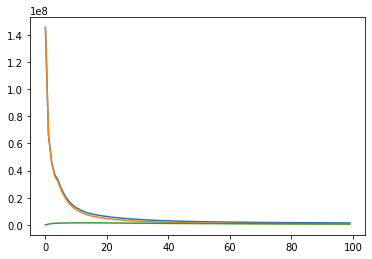

In [22]:
style_transfer_net = style_transfer('vgg19', 'content/content.jpg', 'styles/style.jpg')
style_transfer_net.combine(100, 5, 'output.png')

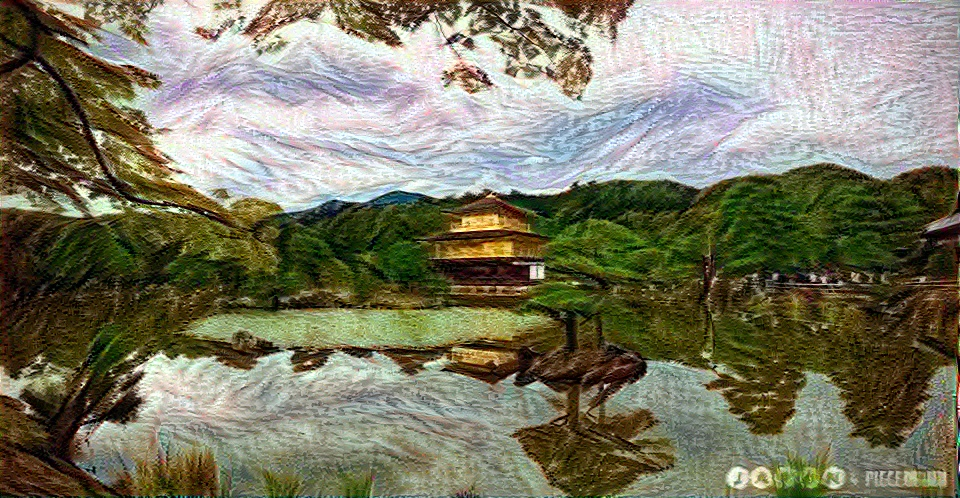



the intermediate outputs are :


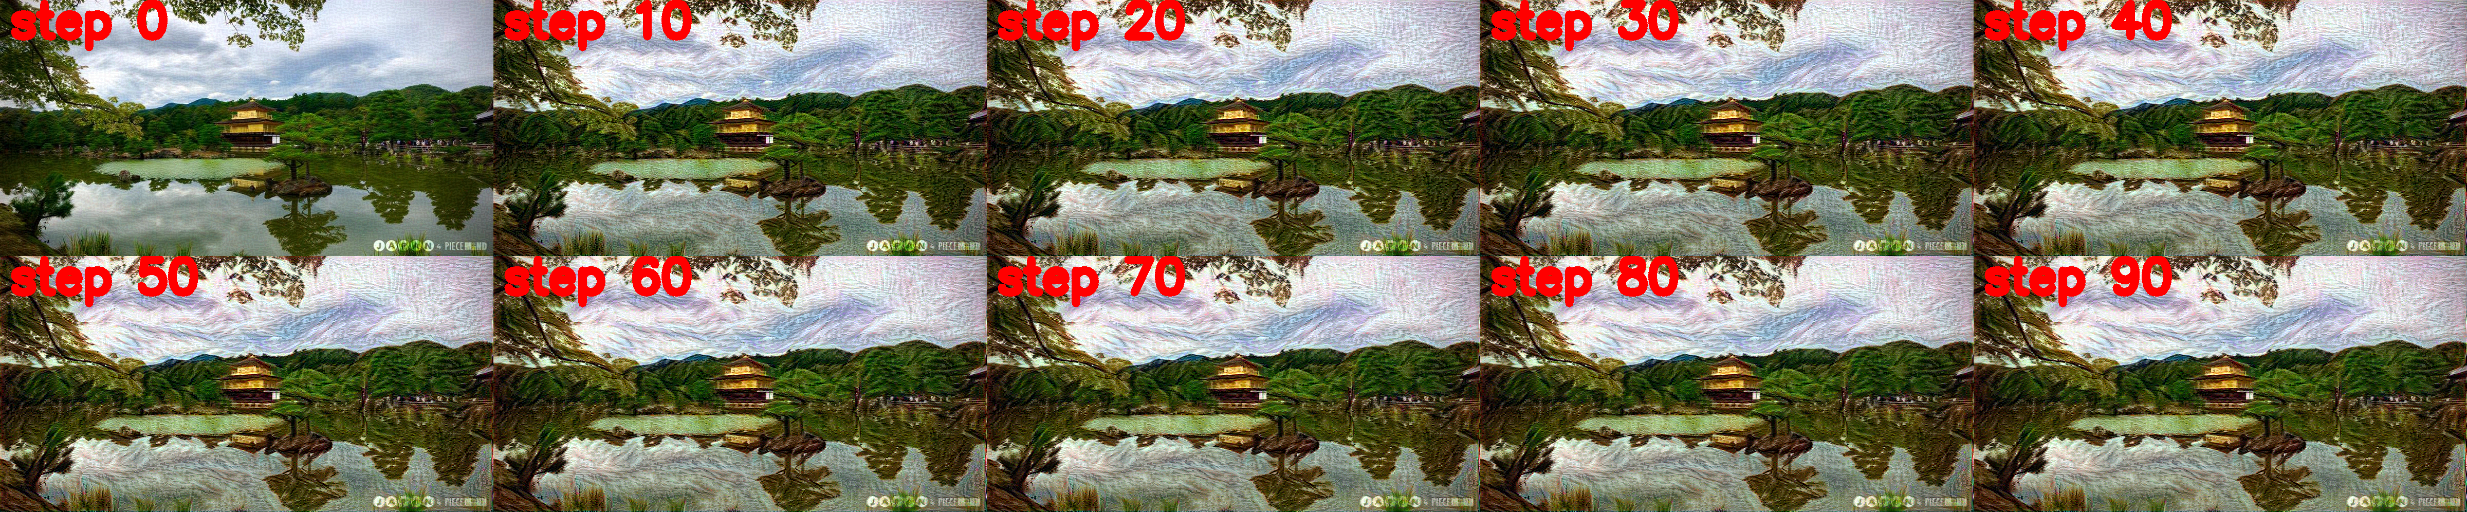

In [23]:
output = cv2.imread('output.jpg')
intermediate_image = cv2.imread('intermediate_images.png')
w = 512
r = intermediate_image.shape[0] / w
intermediate_image = cv2.resize(intermediate_image, (int(intermediate_image.shape[1] / r), w))
cv2_imshow(output)

print ("\n\nthe intermediate outputs are :")
cv2_imshow(intermediate_image)